In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

In [ ]:
! pip install lovely-tensors -q
import lovely_tensors as lt
lt.monkey_patch()

# Render a textured mesh

This tutorial shows how to:
- load a mesh and textures from an `.obj` file.
- set up a renderer
- render the mesh
- vary the rendering settings such as lighting and camera position
- use the batching features of the pytorch3d API to render the mesh from different viewpoints

## 0. Install and Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [ ]:
import os
import sys
import torch
import subprocess
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install fvcore iopath
    if sys.platform.startswith("linux"):
        print("Trying to install wheel for PyTorch3D")
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
        pip_list = !pip freeze
        need_pytorch3d = not any(i.startswith("pytorch3d==") for  i in pip_list)
    if need_pytorch3d:
        print(f"failed to find/install wheel for {version_str}")
if need_pytorch3d:
    print("Installing PyTorch3D from source")
    !pip install ninja
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61395 sha256=9c3eb6fa61048e1aaf7f00b04b2443bed86154b6ac77923a4389a17e05c6eafe
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31529 sha256=1c4101f18f58b3028f7f70c2f8a0580fa71fbdd1577b3da2eae8c24af7cc431e
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Trying to install wheel for PyTorch3D
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt240/download.html
ERROR: Could not find a version that satisfies the

In [ ]:
! pip install plotly -q

## 1. Define new lighting class called EnvMapLights

1.   List item
2.   List item



In [ ]:
import torch
import torch.nn.functional as F

from pytorch3d.common.datatypes import Device
from pytorch3d.renderer.utils import convert_to_tensors_and_broadcast, TensorProperties
from pytorch3d.renderer.lighting import _validate_light_properties

class EnvMapLights(TensorProperties):
    def __init__(
        self,
        ambient_color=((0., 0., 0.),),
        diffuse_color=((0.8, 0.8, 0.8),),
        specular_color=((0.4, 0.4, 0.4),),
        device: Device = "cpu",
    ) -> None:
        """
        Args:
            ambient_color: RGB color of the ambient component.
            diffuse_color: RGB color of the diffuse component.
            specular_color: RGB color of the specular component.
            device: Device (as str or torch.device) on which the tensors should be located

        The inputs can each be
            - 3 element tuple/list or list of lists
            - torch tensor of shape (1, 3)
            - torch tensor of shape (N, 3)
        The inputs are broadcast against each other so they all have batch
        dimension N.
        """
        super().__init__(
            device=device,
            ambient_color=ambient_color,
            diffuse_color=diffuse_color,
            specular_color=specular_color,
        )
        _validate_light_properties(self)

    def clone(self):
        other = self.__class__(device=self.device)
        return super().clone(other)

    def _convert_to_uv(self, directions):
        """
        Convert 3D Cartesian coordinates to 2D UV coordinates in the range [-1, 1].

        Args:
            points: (N, ..., 3) Tensor with Cartesian coordinates.

        Returns:
            uv_points: (N, ..., 2) Tensor with UV coordinates.
        """
        # Calculate the square of each component (x, y, z+1)
        x2 = directions[..., 0] ** 2
        y2 = directions[..., 1] ** 2
        z2 = (directions[..., 2] + 1) ** 2

        # Compute the scaling factor 'm'
        # 'm' is twice the square root of the sum of the squares of the x, y, and z+1 coordinates
        m = 2 * torch.sqrt(x2 + y2 + z2)[..., None]

        # Scale the x and y coordinates by 'm' to normalize them
        uv_directions = directions[..., :2] / m

        # Shift the normalized coordinates to the [0, 1] range by adding 0.5
        uv_directions = uv_directions + 0.5

        # Rescale the coordinates to the [-1, 1] range
        uv_directions = uv_directions * 2 - 1

        return uv_directions

    def diffuse(self, normals, points=None) -> torch.Tensor:
        """
        Calculate the diffuse component of light reflection using Lambert's
        cosine law.

        Args:
            normals: (N, ..., 3) xyz normal vectors. Normals and points are
                expected to have the same shape.
            color: (1, 3) or (N, 3) RGB color of the diffuse component of the light.
            direction: (x,y,z) direction of the light

        Returns:
            colors: (N, ..., 3), same shape as the input points.

        The normals and light direction should be in the same coordinate frame
        i.e. if the points have been transformed from world -> view space then
        the normals and direction should also be in view space.

        NOTE: to use with the packed vertices (i.e. no batch dimension) reformat the
        inputs in the following way.

        .. code-block:: python

            Args:
                normals: (P, 3)
                color: (N, 3)[batch_idx, :] -> (P, 3)
                direction: (N, 3)[batch_idx, :] -> (P, 3)

            Returns:
                colors: (P, 3)

            where batch_idx is of shape (P). For meshes, batch_idx can be:
            meshes.verts_packed_to_mesh_idx() or meshes.faces_packed_to_mesh_idx()
            depending on whether points refers to the vertex coordinates or
            average/interpolated face coordinates.
        """
        # TODO: handle multiple directional lights per batch element.
        # TODO: handle attenuation.
        # Ensure color and location have same batch dimension as normals
        normals, color = convert_to_tensors_and_broadcast(
            normals, self.diffuse_color, device=normals.device
        )
        # dimensions as normals. Assume first dim = batch dim and last dim = 3.
        points_dims = normals.shape[1:-1]
        expand_dims = (-1,) + (1,) * len(points_dims) + (3,)
        # Reshape color so they have all the arbitrary intermediate
        if color.shape != normals.shape:
            if color.dim() == 2 and color.shape[1] == 3:
                color = color.view(expand_dims)
            elif color.dim() == normals.dim() - 1:
                color = color.unsqueeze(-2)
        # Renormalize the normals in case they have been interpolated.
        # We tried to replace the following with F.cosine_similarity, but it wasn't faster.
        normals = F.normalize(normals, p=2, dim=-1, eps=1e-6)
        uv_normals = self._convert_to_uv(normals)

        # Convert color from (B, H, W, 1, 3) to (B, 3, H, W) for sampling
        # Convert uv normals from (B, H, W, 1, 2) to (B, H, W, 2)
        input_color = color.squeeze(-2).permute(0, 3, 1, 2)
        grid_uv_normals = uv_normals.squeeze(-2)

        sampled_color = torch.nn.functional.grid_sample(input_color, grid_uv_normals, padding_mode="reflection", align_corners=False)
        color = sampled_color.permute(0, 2, 3, 1).unsqueeze(-2)

        return color

    def specular(self, normals, points, camera_position, shininess) -> torch.Tensor:
        """
        Calculate the specular component of light reflection.

        Args:
            points: (N, ..., 3) xyz coordinates of the points.
            normals: (N, ..., 3) xyz normal vectors for each point.
            direction: (N, 3) vector direction of the light.
            camera_position: (N, 3) The xyz position of the camera.
            shininess: (N)  The specular exponent of the material.

        Returns:
            colors: (N, ..., 3), same shape as the input points.

        The points, normals, camera_position, and direction should be in the same
        coordinate frame i.e. if the points have been transformed from
        world -> view space then the normals, camera_position, and light direction
        should also be in view space.

        To use with a batch of packed points reindex in the following way.
        .. code-block:: python::

            Args:
                points: (P, 3)
                normals: (P, 3)
                color: (N, 3)[batch_idx] -> (P, 3)
                direction: (N, 3)[batch_idx] -> (P, 3)
                camera_position: (N, 3)[batch_idx] -> (P, 3)
                shininess: (N)[batch_idx] -> (P)
            Returns:
                colors: (P, 3)

            where batch_idx is of shape (P). For meshes batch_idx can be:
            meshes.verts_packed_to_mesh_idx() or meshes.faces_packed_to_mesh_idx().
        """
        # TODO: handle multiple directional lights
        # TODO: attenuate based on inverse squared distance to the light source

        if points.shape != normals.shape:
            msg = "Expected points and normals to have the same shape: got %r, %r"
            raise ValueError(msg % (points.shape, normals.shape))

        # Ensure all inputs have same batch dimension as points
        matched_tensors = convert_to_tensors_and_broadcast(
            points, self.specular_color, camera_position, shininess, device=points.device
        )
        _, color, camera_position, shininess = matched_tensors
        # Reshape color so they have all the arbitrary intermediate
        # dimensions as points. Assume first dim = batch dim and last dim = 3.
        points_dims = points.shape[1:-1]
        expand_dims = (-1,) + (1,) * len(points_dims)
        if camera_position.shape != normals.shape:
            camera_position = camera_position.view(expand_dims + (3,))
        if shininess.shape != normals.shape:
            shininess = shininess.view(expand_dims)
        if color.shape != normals.shape:
            if color.dim() == 2 and color.shape[1] == 3:
                color = color.view(expand_dims + (3,))
            elif color.dim() == normals.dim() - 1:
                color = color.unsqueeze(-2)
        # Renormalize the normals in case they have been interpolated.
        # We tried a version that uses F.cosine_similarity instead of renormalizing,
        # but it was slower.
        normals = F.normalize(normals, p=2, dim=-1, eps=1e-6)

        # Calculate the specular reflection.
        view_direction = camera_position - points
        view_direction = F.normalize(view_direction, p=2, dim=-1, eps=1e-6)

        cos_angle = torch.sum(normals * view_direction, dim=-1)
        # No specular highlights if angle is less than 0.
        mask = (cos_angle > 0).to(torch.float32)


        reflect_direction = -view_direction + 2 * (cos_angle[..., None] * normals)
        reflect_direction = torch.nn.functional.normalize(reflect_direction, dim=-1)

        uv_reflect_direction = self._convert_to_uv(reflect_direction)
        # Convert color from (B, H, W, 1, 3) to (B, 3, H, W) for sampling
        # Convert uv reflect directions from (B, H, W, 1, 2) to (B, H, W, 2)
        input_color = color.squeeze(-2).permute(0, 3, 1, 2)
        grid_uv_reflect_direction = uv_reflect_direction.squeeze(-2)

        sampled_color = torch.nn.functional.grid_sample(input_color, grid_uv_reflect_direction, padding_mode="reflection", align_corners=False)
        # Convert from sampled color (B, 3, H, W) to (B, H, W, 1, 3) like normals dims
        color = sampled_color.permute(0, 2, 3, 1).unsqueeze(-2)

        # Cosine of the angle between the reflected light ray and the viewer
        alpha = F.relu(torch.sum(view_direction * reflect_direction, dim=-1)) * mask
        return color * torch.pow(alpha, shininess)[..., None]

In [ ]:

import os
import torch
import matplotlib.pyplot as plt
import sys

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions
import sys
import os
sys.path.append(os.path.abspath(''))

If using **Google Colab**, fetch the utils file for plotting image grids:

In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2024-08-28 15:25:32--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2024-08-28 15:25:32 (30.3 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]



### 2. Load a mesh and texture file

Load an `.obj` file and its associated `.mtl` file and create a **Textures** and **Meshes** object.

**Meshes** is a unique datastructure provided in PyTorch3D for working with batches of meshes of different sizes.

**TexturesUV** is an auxiliary datastructure for storing vertex uv and texture maps for meshes.

**Meshes** has several class methods which are used throughout the rendering pipeline.

If running this notebook using **Google Colab**, run the following cell to fetch the mesh obj and texture files and save it at the path `data/cow_mesh`:
If running locally, the data is already available at the correct path.

In [ ]:
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2024-06-17 12:22:14--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.15, 13.226.210.111, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj’

cow.obj             100%[===================>] 322.91K  --.-KB/s    in 0.03s   

2024-06-17 12:22:14 (9.03 MB/s) - ‘data/cow_mesh/cow.obj’ saved [330659/330659]

--2024-06-17 12:22:14--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.15, 13.226.210.111, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl’

cow.mtl             100%

In [ ]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

#### Let's visualize the texture map

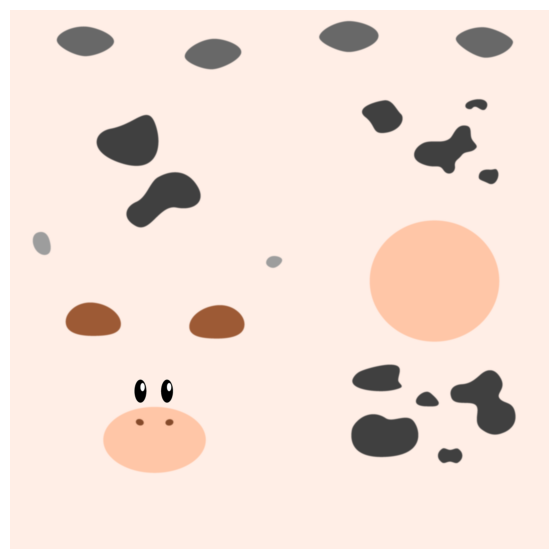

In [ ]:
plt.figure(figsize=(7,7))
texture_image=mesh.textures.maps_padded()
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.axis("off");

PyTorch3D has a built-in way to view the texture map with matplotlib along with the points on the map corresponding to vertices. There is also a method, texturesuv_image_PIL, to get a similar image which can be saved to a file.

In [ ]:
# plt.figure(figsize=(7,7))
# texturesuv_image_matplotlib(mesh.textures, subsample=None)
# plt.axis("off");

## 3. Create a renderer

A renderer in PyTorch3D is composed of a **rasterizer** and a **shader** which each have a number of subcomponents such as a **camera** (orthographic/perspective). Here we initialize some of these components and use default values for the rest.

In this example we will first create a **renderer** which uses a **perspective camera**, a **point light** and applies **Phong shading**. Then we learn how to vary different components using the modular API.  

In [ ]:
from pytorch3d.renderer.mesh.shader import Materials
materials = Materials(device=device)

In [ ]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction.
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow.
R, T = look_at_view_transform(2.7, 0, 180)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of
# the difference between naive and coarse-to-fine rasterization.
raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the
# -z direction.
lights = PointLights(device=device, location=[[0.0, 0.0, -0.5]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will
# interpolate the texture uv coordinates for each vertex, sample from a texture image and
# apply the Phong lighting model

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=cameras,
        lights=EnvMapLights(device=device),
    ),
)

In [ ]:
img = renderer(mesh, lights=EnvMapLights(device=device))

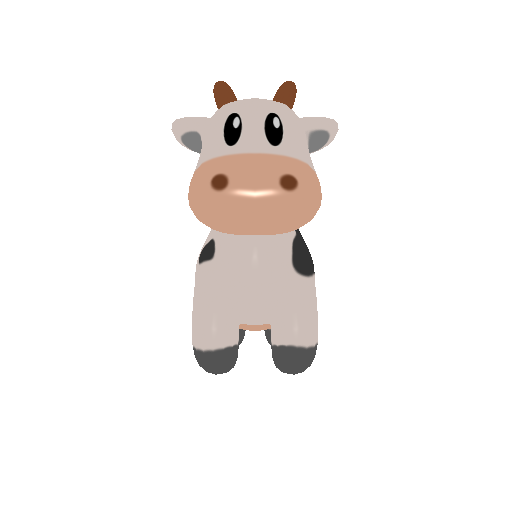

In [ ]:
img[0, ..., :3].permute(2, 0, 1).rgb

## 4. Create a SphericalHarmonics class
This class needed to convert spherical harmonics to HxWx3 environment map to simulate lighting of the scene

In [ ]:
import torch
import math
import numpy as np

'''
code taken and adapted from pyredner
'''

# Code adapted from "Spherical Harmonic Lighting: The Gritty Details", Robin Green
# http://silviojemma.com/public/papers/lighting/spherical-harmonic-lighting.pdf
class SphericalHarmonics:
    def __init__(self, envMapResolution, device):
        self.device = device
        self.setEnvironmentMapResolution(envMapResolution)

    def setEnvironmentMapResolution(self, res):
        res = (res, res)
        self.resolution = res
        uv = np.mgrid[0:res[1], 0:res[0]].astype(np.float32)
        self.theta = torch.from_numpy((math.pi / res[1]) * (uv[1, :, :] + 0.5)).to(self.device)
        self.phi = torch.from_numpy((2 * math.pi / res[0]) * (uv[0, :, :] + 0.5)).to(self.device)

    def smoothSH(self, coeffs, window=6):
        ''' multiply (convolve in sptial domain) the coefficients with a low pass filter.
        Following the recommendation in https://www.ppsloan.org/publications/shdering.pdf
        '''
        smoothed_coeffs = torch.zeros_like(coeffs)
        smoothed_coeffs[:, 0] += coeffs[:, 0]
        smoothed_coeffs[:, 1:1 + 3] += \
            coeffs[:, 1:1 + 3] * math.pow(math.sin(math.pi * 1.0 / window) / (math.pi * 1.0 / window), 4.0)
        smoothed_coeffs[:, 4:4 + 5] += \
            coeffs[:, 4:4 + 5] * math.pow(math.sin(math.pi * 2.0 / window) / (math.pi * 2.0 / window), 4.0)
        smoothed_coeffs[:, 9:9 + 7] += \
            coeffs[:, 9:9 + 7] * math.pow(math.sin(math.pi * 3.0 / window) / (math.pi * 3.0 / window), 4.0)
        return smoothed_coeffs


    def associatedLegendrePolynomial(self, l, m, x):
        pmm = torch.ones_like(x)
        if m > 0:
            somx2 = torch.sqrt((1 - x) * (1 + x))
            fact = 1.0
            for i in range(1, m + 1):
                pmm = pmm * (-fact) * somx2
                fact += 2.0
        if l == m:
            return pmm
        pmmp1 = x * (2.0 * m + 1.0) * pmm
        if l == m + 1:
            return pmmp1
        pll = torch.zeros_like(x)
        for ll in range(m + 2, l + 1):
            pll = ((2.0 * ll - 1.0) * x * pmmp1 - (ll + m - 1.0) * pmm) / (ll - m)
            pmm = pmmp1
            pmmp1 = pll
        return pll


    def normlizeSH(self, l, m):
        return math.sqrt((2.0 * l + 1.0) * math.factorial(l - m) / \
                         (4 * math.pi * math.factorial(l + m)))

    def SH(self, l, m, theta, phi):
        if m == 0:
            return self.normlizeSH(l, m) * self.associatedLegendrePolynomial(l, m, torch.cos(theta))
        elif m > 0:
            return math.sqrt(2.0) * self.normlizeSH(l, m) * \
                   torch.cos(m * phi) * self.associatedLegendrePolynomial(l, m, torch.cos(theta))
        else:
            return math.sqrt(2.0) * self.normlizeSH(l, -m) * \
                   torch.sin(-m * phi) * self.associatedLegendrePolynomial(l, -m, torch.cos(theta))

    def toEnvMap(self, shCoeffs, smooth = False):
        '''
        create an environment map from given sh coeffs
        :param shCoeffs: float tensor [n, bands * bands, 3]
        :param smooth: if True, the first 3 bands are smoothed
        :return: environment map tensor [n, resX, resY, 3]
        '''
        assert(shCoeffs.dim() == 3 and shCoeffs.shape[-1] == 3)
        envMaps = torch.zeros( [shCoeffs.shape[0], self.resolution[0], self.resolution[1], 3]).to(shCoeffs.device)
        for i in range(shCoeffs.shape[0]):
            envMap = self.constructEnvMapFromSHCoeffs(shCoeffs[i], smooth)
            envMaps[i] = envMap
        return envMaps

    def constructEnvMapFromSHCoeffs(self, shCoeffs, smooth = False):

        assert (isinstance(shCoeffs, torch.Tensor) and shCoeffs.dim() == 2 and shCoeffs.shape[1] == 3)

        if smooth:
            smoothed_coeffs = self.smoothSH(shCoeffs.transpose(0, 1), 4)
        else:
            smoothed_coeffs =  shCoeffs.transpose(0, 1) #self.smoothSH(shCoeffs.transpose(0, 1), 4) #smooth the first three bands?

        res = self.resolution

        theta = self.theta
        phi =  self.phi
        result = torch.zeros(res[0], res[1], smoothed_coeffs.shape[0], device=smoothed_coeffs.device)
        bands = int(math.sqrt(smoothed_coeffs.shape[1]))
        i = 0

        for l in range(bands):
            for m in range(-l, l + 1):
                sh_factor = self.SH(l, m, theta, phi)
                result = result + sh_factor.view(sh_factor.shape[0], sh_factor.shape[1], 1) * smoothed_coeffs[:, i]
                i += 1
        result = torch.max(result, torch.zeros(res[0], res[1], smoothed_coeffs.shape[0], device=smoothed_coeffs.device))
        return result


## 5. Render the mesh

The light is in front of the object so it is bright and the image has specular highlights.

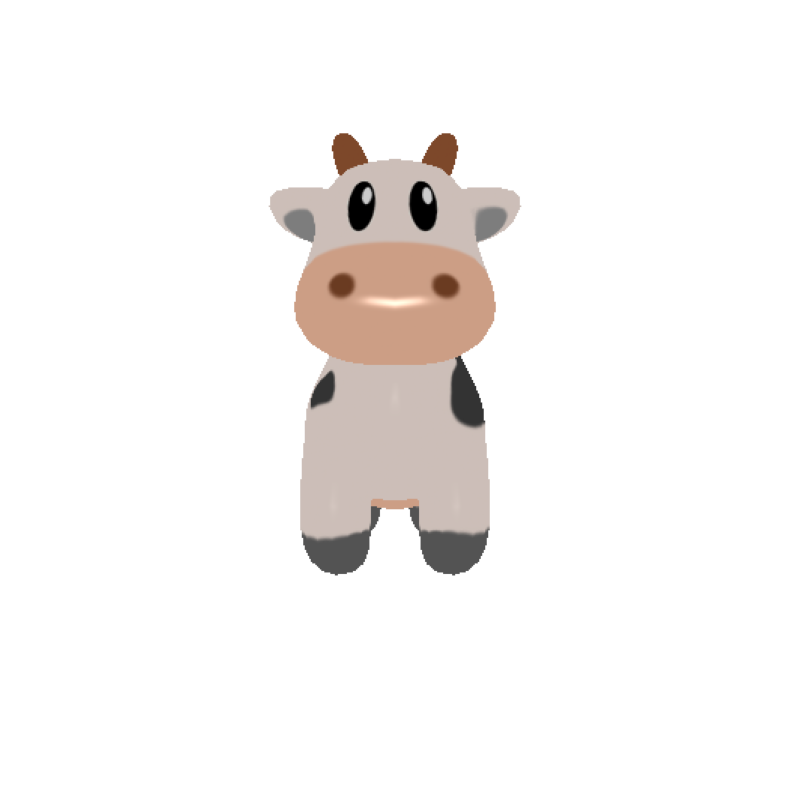

In [ ]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

## 6. Batched Rendering with PointLight

One of the core design choices of the PyTorch3D API is to support **batched inputs for all components**.
The renderer and associated components can take batched inputs and **render a batch of output images in one forward pass**. We will now use this feature to render the mesh from many different viewpoints.


In [ ]:
# Rotate the object by increasing the elevation and azimuth angles
# Set batch size - this is the number of different viewpoints from which we want to render the mesh.
batch_size = 10

point_lights = PointLights(device=device)


# Create a batch of meshes by repeating the cow mesh and associated textures.
# Meshes has a useful `extend` method which allows us do this very easily.
# This also extends the textures.
meshes = mesh.extend(batch_size)

# Get a batch of viewing angles.
elev = torch.linspace(0, 180, batch_size)
azim = torch.linspace(-180, 180, batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can
# view the camera from the same distance and specify dist=2.7 as a float,
# and then specify elevation and azimuth angles for each viewpoint as tensors.
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Move the light location so the light is shining on the cow's face.
point_lights.location = torch.tensor([[2.0, 2.0, -2.0]], device=device)

# Change specular color to green and change material shininess
materials = Materials(
    device=device,
    specular_color=[[1, 1.0, 1]],
    shininess=10.0
)

# Re render the mesh, passing in keyword arguments for the modified components.
images = renderer(meshes, lights=point_lights, materials=materials, cameras=cameras)

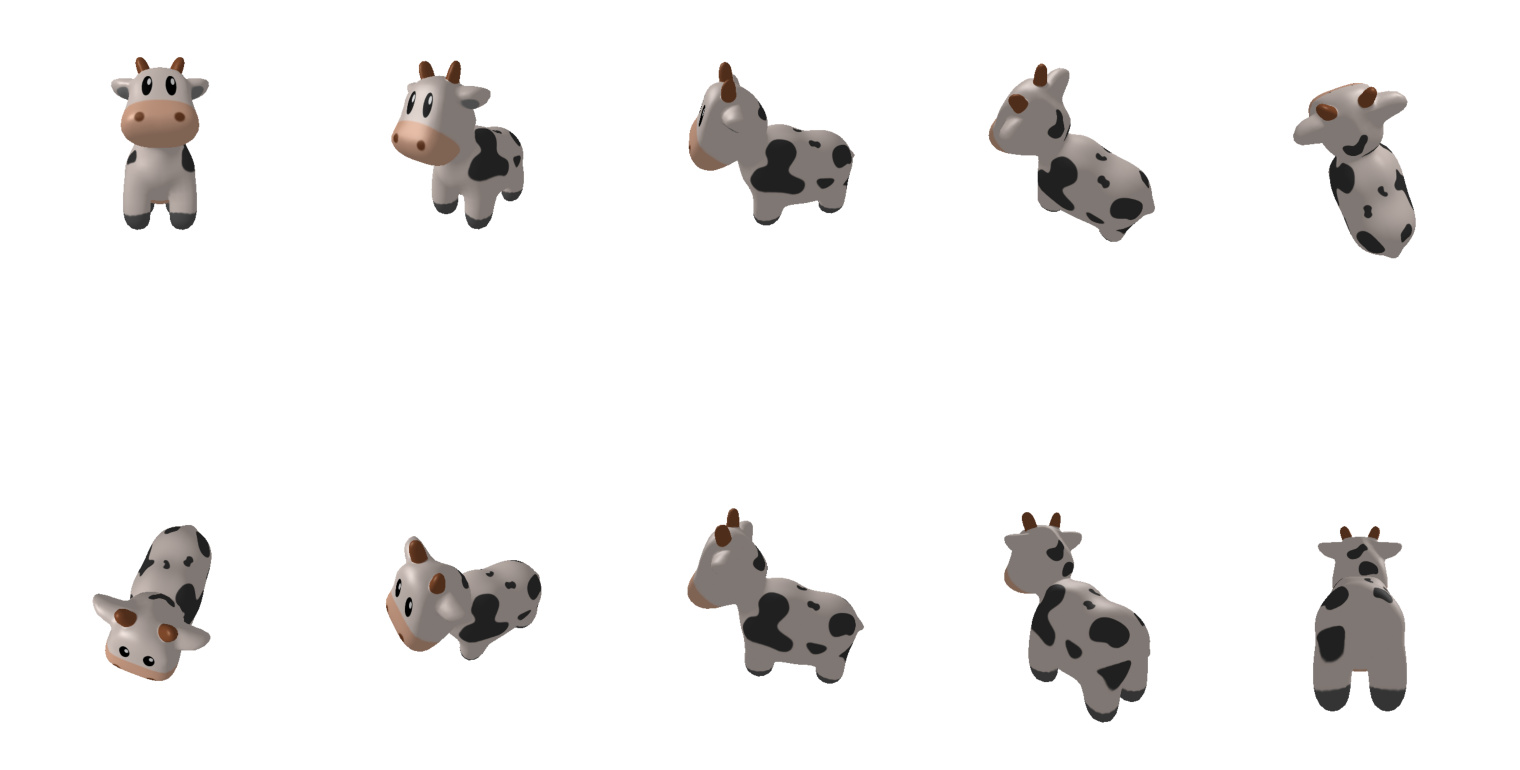

In [ ]:
image_grid(images.cpu().numpy(), rows=2, cols=5, rgb=True)

## 7. Batched Rendering with EnvMapLights

Render with the same angles to simulate point lights via environment map with analysis-by-synthesis


In [ ]:
sh = SphericalHarmonics(128, device='cuda:0')

batch_size = 1
band = 9
learning_rate = 0.02
num_epochs = 300  # Adjust as needed

# Initialize coefficients
diffuse_sh_coefs = torch.ones((batch_size, band, 3), device='cuda:0')
diffuse_sh_coefs.requires_grad = True


specular_sh_coefs = torch.ones((batch_size, band, 3), device='cuda:0')
specular_sh_coefs.requires_grad = True

# Define loss function and optimizer
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam([diffuse_sh_coefs, specular_sh_coefs], lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Generate environment map from spherical harmonics coefficients
    diffuse_envmap = sh.toEnvMap(diffuse_sh_coefs).clip(0, 1)
    specular_envmap = sh.toEnvMap(specular_sh_coefs).clip(0, 1)

    pred_images = renderer(meshes, lights=EnvMapLights(diffuse_color=diffuse_envmap,
                                                       specular_color=specular_envmap,
                                                       device=device), materials=materials, cameras=cameras)
    loss = loss_function(pred_images, images)

    # Backpropagation and optimization step
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:  # Print progress every 100 epochs
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')


print("Training finished!")

Epoch [0/300], Loss: 0.02157040685415268
Epoch [10/300], Loss: 0.019202349707484245
Epoch [20/300], Loss: 0.016491243615746498
Epoch [30/300], Loss: 0.012465112842619419
Epoch [40/300], Loss: 0.010623743757605553
Epoch [50/300], Loss: 0.007512185722589493
Epoch [60/300], Loss: 0.0023784206714481115
Epoch [70/300], Loss: 0.001665260293520987
Epoch [80/300], Loss: 0.001225538901053369
Epoch [90/300], Loss: 0.0010508482810109854
Epoch [100/300], Loss: 0.0009151078993454576
Epoch [110/300], Loss: 0.0008145865285769105
Epoch [120/300], Loss: 0.0007360458839684725
Epoch [130/300], Loss: 0.0006630917778238654
Epoch [140/300], Loss: 0.0005953295039944351
Epoch [150/300], Loss: 0.0005312289576977491
Epoch [160/300], Loss: 0.0004705856554210186
Epoch [170/300], Loss: 0.0004140364471822977
Epoch [180/300], Loss: 0.0003621821815613657
Epoch [190/300], Loss: 0.00031542807118967175
Epoch [200/300], Loss: 0.0002740961208473891
Epoch [210/300], Loss: 0.00023711864196229726
Epoch [220/300], Loss: 0.000

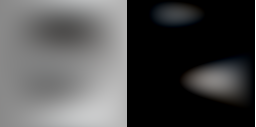

In [ ]:
# Diffuse and specular envmaps
torch.cat([diffuse_envmap, specular_envmap], dim=-2).squeeze().permute(2, 0, 1).rgb

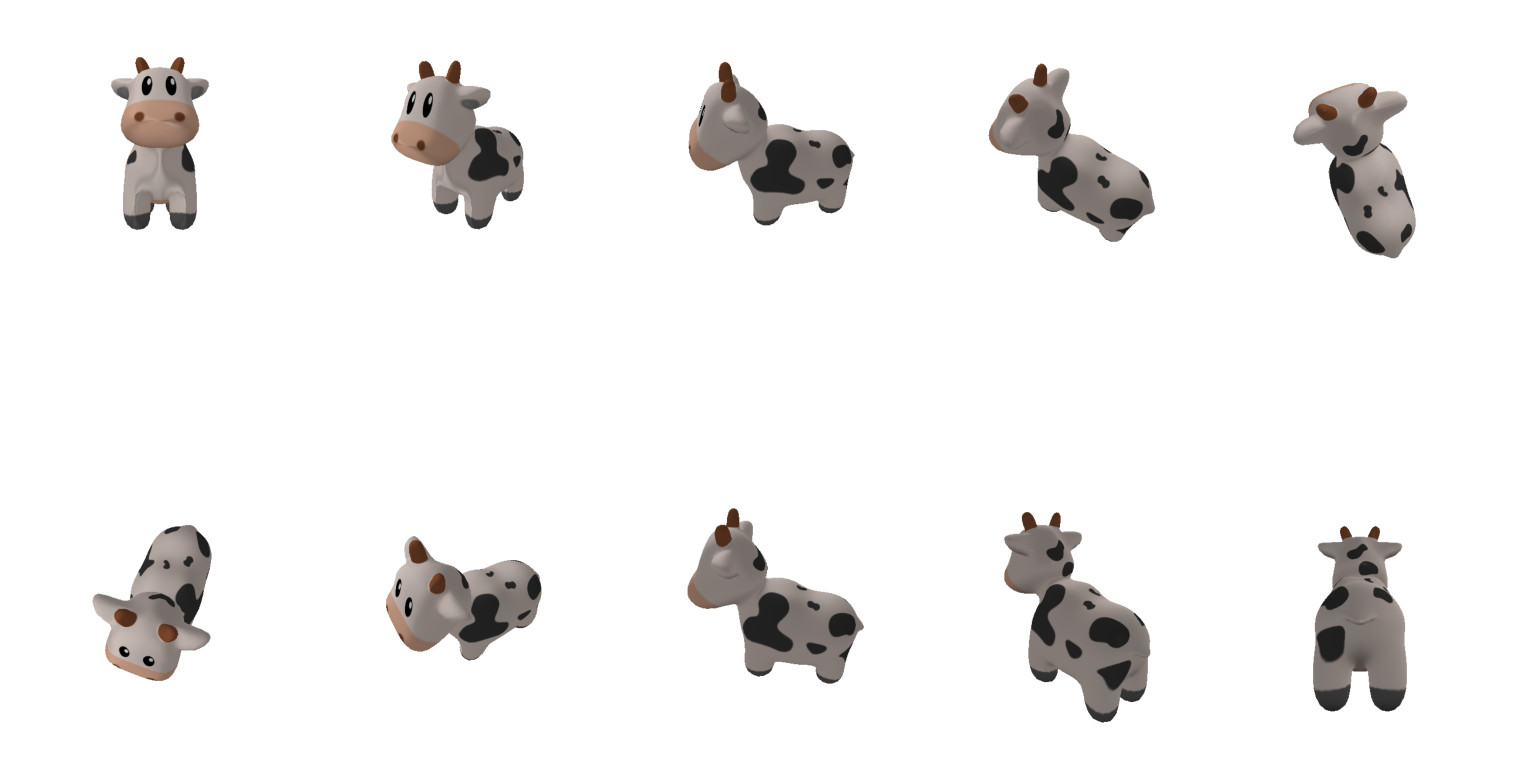

In [ ]:
image_grid(pred_images.detach().cpu().numpy(), rows=2, cols=5, rgb=True)